In [1]:
using Knet
using AutoGrad
using Images
using ImageMagick
using Random
using PyPlot
using Statistics
import Base: length, size, iterate, eltype, IteratorSize, IteratorEltype, haslength, @propagate_inbounds, repeat, rand, tail
import .Iterators: cycle, Cycle, take
using IterTools: ncycle, takenth
import CUDA
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32,N} where N

Start by loading list of images to be used

In [2]:
dataPath = "GeNeVA-v1\\i-CLEVR\\images"
files = readdir(dataPath);

Select images containing single object

In [3]:
singleObj = files[endswith.(files, "_0.png")]
singleObj = ["$(dataPath)\\$(file)" for file in singleObj];

Create iterator for Clevr Dataset

In [245]:
struct ClevrData
    files
    batchsize::Int
    #shuffle::Bool
    num_instances::Int

    function ClevrData(files; batchsize::Int=5) #shuffle::Bool=false)
        new(files, batchsize, length(files))
    end
end

In [246]:
function length(d::ClevrData)
    nFullBatches, rem = divrem(d.num_instances, d.batchsize)
    nFullBatches + (rem > 0)*1
end

length (generic function with 210 methods)

In [247]:
function load_image(filename)
    img = load(filename)
    img = imresize(img, (64,64))
    img = Float64.(channelview(img))
    img = img[1:3,:,:]
    img = permutedims(img, [2, 3, 1])
#     img = reshape(img, (64,64,3,1))
#     img = convert(array_type, img)
end

load_image (generic function with 1 method)

In [248]:
function iterate(d::ClevrData, state=collect(1:d.num_instances))
    if length(state) > 0
        batch = d.files[state[1:(length(state) < d.batchsize ? end : d.batchsize)]]
        state  = state[d.batchsize+1:end]
        out = convert(array_type, zeros(64,64,3,length(batch)))
        ims = load_image.(batch)
        for i in collect(1:length(batch)); out[:,:,:,i] = ims[i]; end
        return (Param(out)), state
    end
end

iterate (generic function with 432 methods)

In [496]:
?sgd!

search: sgd! sgd Sgd SGD signed Signed using3D Unsigned unsigned colorsigned



```
minimize(func, data, optimizer=Adam(); params)
sgd     (func, data; lr=0.1,  gclip, params)
momentum(func, data; lr=0.05, gamma=0.95, gclip, params)
nesterov(func, data; lr=0.05, gamma=0.95, gclip, params)
adagrad (func, data; lr=0.05, eps=1e-6, gclip, params)
rmsprop (func, data; lr=0.01, rho=0.9, eps=1e-6, gclip, params)
adadelta(func, data; lr=1.0,  rho=0.9, eps=1e-6, gclip, params)
adam    (func, data; lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, gclip, params)
```

Return an iterator which applies `func` to arguments in `data`, i.e.  `(func(args...) for args in data)`, and updates the parameters every iteration to minimize `func`.  `func` should return a scalar value.

The common keyword argument `params` can be used to list the `Param`s to be optimized.  If not specified, any `Param` that takes part in the computation of `func(args...)` will be updated.

The common keyword argument `gclip` can be used to implement per-parameter gradient clipping. For a parameter gradient `g`, if `norm(g) > gclip > 0`, `g` is scaled so that its norm is equal to `gclip`. If not specified no gradient clipping is performed.

These functions do not perform optimization, but return an iterator that can. Any function that produces values from an iterator can be used with such an object, e.g. `progress!(sgd(f,d))` iterates the sgd optimizer and displays a progress bar. For convenience, appending `!` to the name of the function iterates and returns `nothing`, i.e. `sgd!(...)` is equivalent to `(for x in sgd(...) end)`.

We define optimizers as lazy iterators to have explicit control over them:

  * To report progress use `progress(sgd(f,d))`.
  * To run until convergence use `converge(sgd(f,cycle(d)))`.
  * To run multiple epochs use `sgd(f,repeat(d,n))`.
  * To run a given number of iterations use `sgd(f,take(cycle(d),n))`.
  * To do a task every n iterations use `(task() for (i,j) in enumerate(sgd(f,d)) if i%n == 1)`.

These functions apply the same algorithm with the same configuration to every parameter by default. `minimize` takes an explicit optimizer argument, all others call `minimize` with an appropriate optimizer argument (see `@doc update!` for a list of possible optimizers). Before calling [`update!`](@ref) on a `Param`, `minimize` sets its `opt` field to a copy of this default optimizer if it is not already set. The `opt` field is used by the `update!` function to determine the type of update performed on that parameter.  If you need finer grained control, you can set the optimizer of an individual `Param` by setting its `opt` field before calling one of these functions. They will not override the `opt` field if it is already set, e.g. `sgd(model,data)` will perform an `Adam` update for a parameter whose `opt` field is an `Adam` object. This also means you can stop and start the training without losing optimization state, the first call will set the `opt` fields and the subsequent calls will not override them.

Given a parameter `w` and its gradient `g` here are the updates applied by each optimizer:

```
# sgd (http://en.wikipedia.org/wiki/Stochastic_gradient_descent)
w .= w - lr * g

# momentum (http://jlmelville.github.io/mize/nesterov.html)
v .= gamma * v - lr * g
w .= w + v

# nesterov (http://jlmelville.github.io/mize/nesterov.html)
w .= w - gamma * v
v .= gamma * v - lr * g
w .= w + (1 + gamma) * v

# adagrad (http://www.jmlr.org/papers/v12/duchi11a.html)
G .= G + g .^ 2
w .= w - lr * g ./ sqrt(G + eps)

# rmsprop (http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
G .= rho * G + (1-rho) * g .^ 2 
w .= w - lr * g ./ sqrt(G + eps)

# adadelta (http://arxiv.org/abs/1212.5701)
G .= rho * G + (1-rho) * g .^ 2
update = sqrt(delta + eps) .* g ./ sqrt(G + eps)
w = w - lr * update
delta = rho * delta + (1-rho) * update .^ 2

# adam (http://arxiv.org/abs/1412.6980)
v = beta1 * v + (1 - beta1) * g
G = beta2 * G + (1 - beta2) * g .^ 2
vhat = v ./ (1 - beta1 ^ t)
Ghat = G ./ (1 - beta2 ^ t)
w = w - (lr / (sqrt(Ghat) + eps)) * vhat
```


In [198]:
# for batch in clevrDataset
#     println(length(batch))
# end

In [19]:
function leakyRelu(x)
    max(0.1 .* x, x)
end

leakyRelu (generic function with 1 method)

In [60]:
function Z(dim1, dim2)
    z = (rand(dim1, dim2).*2.0).-1.0
    convert(array_type, z)
end

Z (generic function with 1 method)

In [381]:
function Z2(dim1, dim2, dim3, dim4)
    z = (rand(dim1, dim2, dim3, dim4).*2.0).-1.0
    convert(array_type, z)
end

Z2 (generic function with 2 methods)

In [518]:
function Z3(dim1, dim2, dim3, dim4, dim5)
    z = (rand(dim1, dim2, dim3, dim4, dim5).*2.0).-1.0
    convert(array_type, z)
end

Z3 (generic function with 1 method)

In [20]:
struct Discriminator2
    layers
    Discriminator2(layers...) = new(layers)
end
(model::Discriminator2)(x) = (for l in model.layers; x = l(x); end; x)


In [541]:
struct Generator2
    layers
    Generator2(layers...) = new(layers)
end
# (model::Generator2)(x) = (for l in model.layers; x = l(x); end; x)
function (model::Generator2)(z)
    layers = model.layers
    x = layers[1]()
    for i in collect(2:length(layers))
       x = layers[i](x) 
    end
    x
end

In [515]:
struct ObjectGenerator
    layers
    ObjectGenerator(layers...) = new(layers)
end
(model::ObjectGenerator)(x) = (for l in model.layers; x = l(x); end; x)

In [516]:
struct BackgroundGenerator
    layers
    BackgroundGenerator(layers...) = new(layers)
end
(model::BackgroundGenerator)(x) = (for l in model.layers; x = l(x); end; x)

In [26]:
function dLoss(D::Discriminator2, realIms, fakeIms)
    realLoss = -mean(log.(D(realIms)))
    fakeLoss = -mean(log.(1 .- D(fakeIms)))
    return 0.5*(realLoss+fakeLoss)
end

dLoss (generic function with 1 method)

In [27]:
function gLoss(G::Generator2, D::Discriminator2, z)
    yPr = D(G(z))
    return -0.5*mean(log.(yPr))
end

gLoss (generic function with 1 method)

In [514]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(model::Chain)(x) = (for l in model.layers; x = l(x); end; x)

In [18]:
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=relu) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul

In [153]:
struct Reshape1; x; y; c; end;
Reshape1() = Reshape1(64,64,3)
(r::Reshape1)(x) = reshape(x, r.x, r.y, r.c, :)

In [24]:
struct Reshape3; x; y; c; end;
Reshape3() = Reshape3(64,64,3)
(r::Reshape3)(x) = reshape(x, r.x, r.y, r.c)

In [156]:
struct Reshape2; a end;
Reshape2() = Reshape2(1)
(r::Reshape2)(x) = reshape(x, :,size(x)[end])

In [95]:
struct BNorm; moments; params; act; end;
(bn::BNorm)(x) = if bn.act sigm.(batchnorm(x, bn.moments, bn.params)) else batchnorm(x, bn.moments, bn.params) end

In [372]:
struct Conv; w; b; f; end
(c::Conv)(x) = c.f.(conv4(c.w, x, stride = 2, padding = 2) .+ c.b)
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=leakyRelu) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f)

Conv

In [484]:
struct Deconv; w; f; end
(c::Deconv)(x) = c.f.(deconv4(c.w, x, padding = 0, stride = 1))
Deconv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu) = Deconv(param(w1,w2,cx,cy),f)
Deconv(w1::Int,w2::Int,w3::Int,cx::Int,cy::Int,f=relu) = Deconv(param(w1,w2,w3,cx,cy),f)

Deconv

In [507]:
struct Deconv2; w; f; end
(c::Deconv2)(x) = c.f.(deconv4(c.w, x, padding = 1, stride = 2))
Deconv2(w1::Int,w2::Int,cx::Int,cy::Int,f=relu) = Deconv2(param(w1,w2,cx,cy),f)
Deconv2(w1::Int,w2::Int,w3::Int,cx::Int,cy::Int,f=relu) = Deconv2(param(w1,w2,w3,cx,cy),f)

Deconv2

In [361]:
struct Deconv3; w; f; end
(c::Deconv3)(x) = c.f.(deconv4(c.w, x, padding = 2, stride = 1))
Deconv3(w1::Int,w2::Int,cx::Int,cy::Int,f=relu) = Deconv3(param(w1,w2,cx,cy),f)

Deconv3

In [ ]:
# function unpack(array)
#     objs = size(array)[end]
#     if objs > 1
#         out = [x[:,:,:,:,i]
#     end
# end

In [525]:
function SceneComposer(objs...)
    m  = max.(objs)
    concat = reshape(m, (16,16,16*64,:))
end

SceneComposer (generic function with 2 methods)

In [527]:
function createScene(bgTensor, fgTensor)
    FG = ObjectGenerator(Deconv2(4,4,4,128,512), Deconv2(4,4,4,64,128))
    BG = BackgroundGenerator(Deconv2(4,4,4,128,256), Deconv2(4,4,4,64,128))
    f  = FG(fgTensor)
    b  = BG(bgTensor)
    SceneComposer(f,b)
end

createScene (generic function with 1 method)

In [535]:
struct Scene
    l1
    l2
end
Scene(b::Int,f::Int) = Scene(param(4,4,4,b,1), param(4,4,4,f,1))
(s::Scene)() = createScene(s.l1, s.l2)

In [539]:
Random.seed!(1234)
loss_g = []
loss_d = []

G = Generator2(Scene(256, 512), Deconv(1,1,64,16*64), Deconv2(4,4,64,64), Deconv2(4,4,64,64), Deconv3(5,5,3,64))
D = Discriminator2(Conv(5,5,3,64), Conv(5,5,64,128), Conv(5,5,128,256), Conv(5,5,256,512), Dense(4*4*512,1,sigm))

Discriminator2((Conv(P(KnetArray{Float32,4}(5,5,3,64)), P(KnetArray{Float32,4}(1,1,64,1)), leakyRelu), Conv(P(KnetArray{Float32,4}(5,5,64,128)), P(KnetArray{Float32,4}(1,1,128,1)), leakyRelu), Conv(P(KnetArray{Float32,4}(5,5,128,256)), P(KnetArray{Float32,4}(1,1,256,1)), leakyRelu), Conv(P(KnetArray{Float32,4}(5,5,256,512)), P(KnetArray{Float32,4}(1,1,512,1)), leakyRelu), Dense(P(KnetArray{Float32,2}(1,8192)), P(KnetArray{Float32,1}(1)), Knet.Ops20.sigm)))

In [483]:
?deconv4

search: deconv4 Deconv3 Deconv2 Deconv spacedirections goldensection



```
deconv4(w, x; kwargs...)
```

Simulate 4-D deconvolution by using *transposed convolution* operation. Its forward pass is equivalent to backward pass of a convolution (gradients with respect to input tensor). Likewise, its backward pass (gradients with respect to input tensor) is equivalent to forward pass of a convolution. Since it swaps forward and backward passes of convolution operation, padding and stride options belong to output tensor. See [this report](https://arxiv.org/abs/1603.07285) for further explanation.

If `w` has dimensions `(W1,W2,...,Cy,Cx)` and `x` has dimensions `(X1,X2,...,Cx,N)`, the result `y=deconv4(w,x)` will have dimensions `(Y1,Y2,...,Cy,N)` where

```
Yi = (Xi - 1)*stride[i] + ((Wi-1)*dilation[i] + 1) - 2*padding[i]
```

Here Cx is the number of x channels, Cy is the number of y channels, N is the number of instances, and Wi,Xi,Yi are spatial dimensions. Padding and stride are keyword arguments that can be specified as a single number (in which case they apply to all dimensions), or an array/tuple with entries for each spatial dimension.

# Keywords

  * `padding=0`: the number of extra zeros implicitly concatenated at the start and at the end of each dimension.
  * `stride=1`: the number of elements to slide to reach the next filtering window.
  * `mode=0`: 0 for convolution and 1 for cross-correlation.
  * `alpha=1`: can be used to scale the result.
  * `handle`: handle to a previously created cuDNN context. Defaults to a Knet allocated handle.
  * `group=1`: can be used to perform grouped convolutions.


In [447]:
# for i in ncycle(take(clevrDataset1,20), 100)
#     z = Z2(16,16,16*64,1)
#     @show dLoss(D, i, G(z))
# #     adam!(gLoss, [(G, D, z)], params=params(G))
#     adam!(dLoss, [(D, i, G(z))])#, params=params(D))
# end


dLoss(D, i, G(z)) = 0.6953708529472351
dLoss(D, i, G(z)) = 0.490739107131958
dLoss(D, i, G(z)) = 0.5471761226654053
dLoss(D, i, G(z)) = 0.15956293046474457
dLoss(D, i, G(z)) = 1.9275312423706055
dLoss(D, i, G(z)) = 0.030199842527508736
dLoss(D, i, G(z)) = 0.03598947077989578
dLoss(D, i, G(z)) = 0.019018832594156265
dLoss(D, i, G(z)) = 0.003919986076653004
dLoss(D, i, G(z)) = 0.0003582388162612915
dLoss(D, i, G(z)) = 1.5206959687930066e-5
dLoss(D, i, G(z)) = 3.6266439451537735e-7
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)) = -0.0
dLoss(D, i, G(z)

LoadError: InterruptException:

In [480]:
function main()
    clevrDataset = ClevrData(singleObj)
#     G = Generator2(Dense(128, 12288), Reshape1())
#     D = Discriminator2(Reshape2(), Dense(12288, 1, sigm))
#     loss_g = []
#     loss_d = []
    i = 1
    for real_image in ncycle(take(clevrDataset,20), 100)
        z = Z2(16,16,16*64,1)
        if i % 25 == 0
        adam!(dLoss, [(D, real_image, G(z))])#, params=params(D))
        end
#         if i % 5 == 0
        adam!(gLoss, [(G, D, z)], params=params(G))
#         end
        if i % 100 == 0
            push!(loss_g, gLoss(G, D, z))
            push!(loss_d, dLoss(D, real_image, G(z)))
            print("$(i): GenLoss: ");print(loss_g[end])
            print("    DisLoss: ");println(loss_d[end])
        end
        i += 1
    end
end

main (generic function with 1 method)

In [481]:
Random.seed!(123678)
main()

100: GenLoss: 9.027029037475586

LoadError: InterruptException:

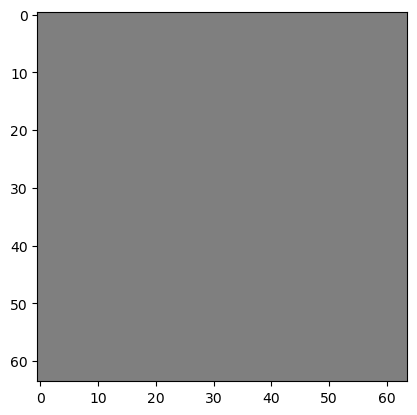

PyObject <matplotlib.image.AxesImage object at 0x000000009A911A00>

In [478]:
img = G(Z2(16,16,16*64,1))[:,:,:,1]
img = convert(Array{Float32}, value(img))
imshow(img)

In [144]:
img = img ./ maximum(img);
#imshow(img);

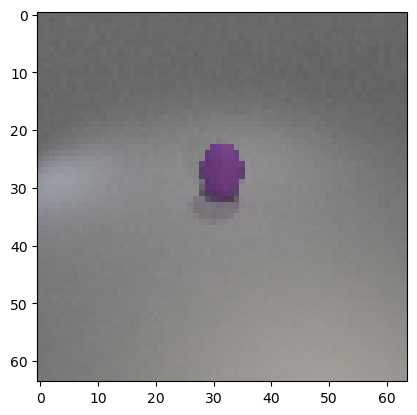

PyObject <matplotlib.image.AxesImage object at 0x0000000063D62460>

In [136]:
clevrDataset1 = ClevrData(singleObj)1
img1= first(take(clevrDataset1, 1))[:,:,:,1]
img1 = convert(Array{Float32}, value(img1))
imshow(img1)

In [467]:
D(first(take(clevrDataset1, 1)))

1×1 KnetArray{Float32,2}:
 0.49700376

In [555]:
# a = Deconv2(4,4,4,128,512)
# a(param(4,4,4,512,1))
# b = Deconv2(4,4,4,64,128)
# b(a(param(4,4,4,512,1)))

In [554]:
# background = ObjectGenerator()
# foreground = ObjectGenerator()
# composedScene = max.(background, foreground)
# concat = reshape(composedScene, (16,16,16*64,1))
# c1 = Conv(1,1,1024,64)
# projected = c1(concat)

In [545]:
# Random.seed!(1234)
# loss_g = []
# loss_d = []
# moments1 = bnmoments()
# params1 = param(bnparams(3))
# G = Generator2(Dense(128, 12288, sigm), Reshape1())
# D = Discriminator2(Conv(5,5,3,64,leakyRelu), Dense(65536, 1, sigm))

In [546]:
# a = Conv(5,5,3,64)
# b = Conv(5,5,64,128)
# c = Conv(5,5,128,256)
# d = Conv(5,5,256,512)
# e = Dense(4*4*512,1,sigm)
# e(d(c(b(a(param(64,64,3,1))))))

In [547]:
# a = Conv(1,1,1024,64)
# a(param(randn(16,16,1024,1)))

In [548]:
# e = a(Z2(16,16,16*64,1))
# f = b(e)
# g = b(f)
# h = c(g)

In [549]:
# a = Deconv2(4,4,64,16*64)

# a(param(16,16,16*64,1))

In [550]:
# x = randn(16, 16, 16*64, 1)
# w = randn(4, 4, 64, 16*64)
# y = deconv4(w, x, stride = 2, padding = 1)

In [551]:
# a = 3
# a(param(randn(16,16,1024,1)))

In [552]:
# a = Deconv(1,1,64,16*64)
# a(param(16,16,16*64,1))
# b = Deconv2(4,4,64,64)
# b(b(param(16,16,64,1)))
# c = Deconv3(5,5,3,64)
# c(param(64,64,64,1))

In [553]:
# function make_minibatch(names, batchSize = 128)
#     rem = mod(length(names), batchSize)
#     names = reshape(names[1:end-rem], :, batchSize)
# end

# batches = make_minibatch(singleObj, 64)
# batch = load_batch(batches, 1)